In [73]:
import db_utils_new as db

In [74]:
# Setting up connection, creating engine and inspecting the data

connector_1 = db.RDSDatabaseConnector(db.credentials_to_dict())
engine_1 = connector_1.init_sql_engine()
extractor_1 = db.Extractor()
loan_payments = extractor_1.get_table_as_df(engine=engine_1, table='loan_payments')


In [75]:
# Checking null percentages and dropping every column over 50% missing

dfinfo_1 = db.DataFrameInfo()
dfinfo_1.check_null_percentages(loan_payments)


id                              0.000000
member_id                       0.000000
loan_amount                     0.000000
funded_amount                   5.544799
funded_amount_inv               0.000000
term                            8.799395
int_rate                        9.531449
instalment                      0.000000
grade                           0.000000
sub_grade                       0.000000
employment_length               3.905515
home_ownership                  0.000000
annual_inc                      0.000000
verification_status             0.000000
issue_date                      0.000000
loan_status                     0.000000
payment_plan                    0.000000
purpose                         0.000000
dti                             0.000000
delinq_2yrs                     0.000000
earliest_credit_line            0.000000
inq_last_6mths                  0.000000
mths_since_last_delinq         57.166565
mths_since_last_record         88.602460
open_accounts   

In [76]:
# Drop all columns where null percentage > 50%

dftransform_1= db.DataFrameTransform()
dftransform_1.drop_column(loan_payments, 'mths_since_last_delinq')
dftransform_1.drop_column(loan_payments, 'mths_since_last_record')
dftransform_1.drop_column(loan_payments, 'next_payment_date')
dftransform_1.drop_column(loan_payments, 'mths_since_last_major_derog')


In [77]:
# Look at other nulls to be addressed
dfinfo_1=db.DataFrameInfo()
dfinfo_1.check_no_of_nulls(loan_payments)

id                               0
member_id                        0
loan_amount                      0
funded_amount                 3007
funded_amount_inv                0
term                          4772
int_rate                      5169
instalment                       0
grade                            0
sub_grade                        0
employment_length             2118
home_ownership                   0
annual_inc                       0
verification_status              0
issue_date                       0
loan_status                      0
payment_plan                     0
purpose                          0
dti                              0
delinq_2yrs                      0
earliest_credit_line             0
inq_last_6mths                   0
open_accounts                    0
total_accounts                   0
out_prncp                        0
out_prncp_inv                    0
total_payment                    0
total_payment_inv                0
total_rec_prncp     

In [78]:
# Let's check the MCAR assumption for each of these nulls. 
import plotly.express as px

dfinfo_1 = db.DataFrameInfo()

cols_with_nulls_ls = dfinfo_1.get_cols_with_nulls(loan_payments)

null_testing_df = loan_payments.copy()

for col in cols_with_nulls_ls:
    null_testing_df[f'{col}_nulls'] = loan_payments[col].isna()

px.imshow(null_testing_df.corr(numeric_only=True), title="Correlation heatmap for checking MCAR of nulls")

Plot for funded_amount


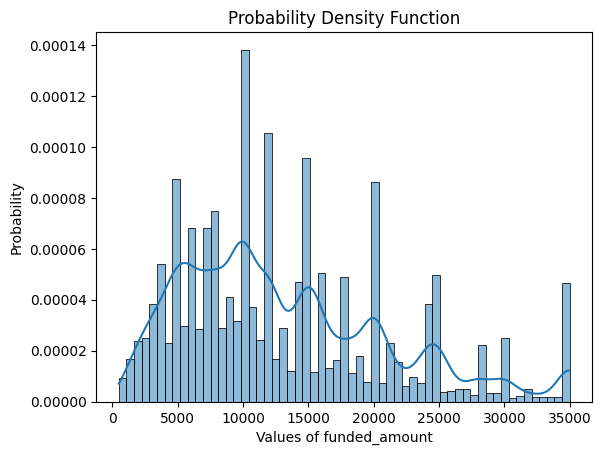

The mode of the distribution is 10000.0
The mean of the distribution is 13229.50911682024
The median of the distribution is 12000.0
Plot for term


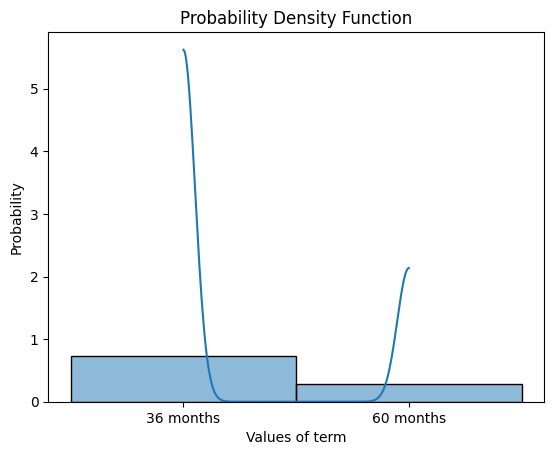

The mode of the distribution is 36 months
Plot for int_rate


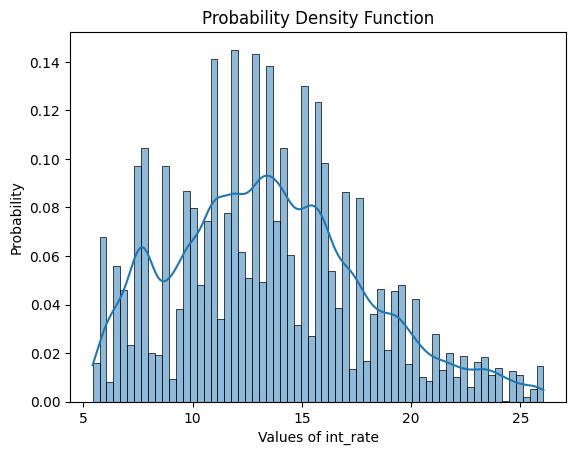

The mode of the distribution is 11.99
The mean of the distribution is 13.507328482328484
The median of the distribution is 13.16
Plot for employment_length


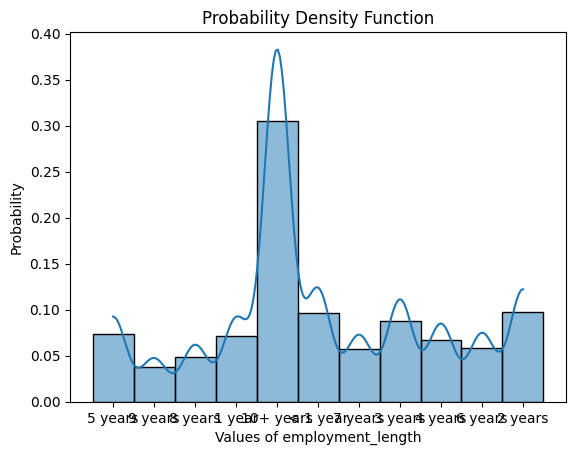

The mode of the distribution is 10+ years
Plot for last_payment_date


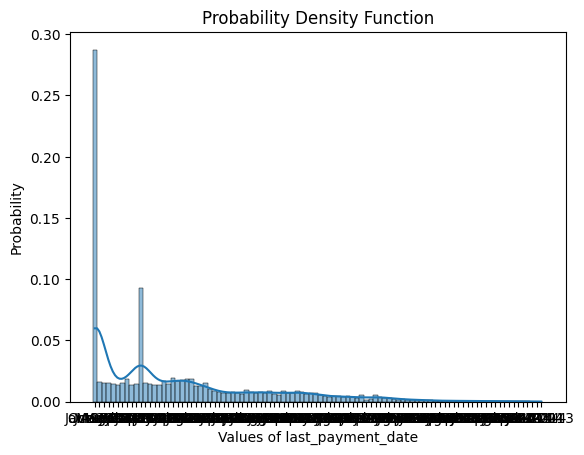

The mode of the distribution is Jan-2022
Plot for last_credit_pull_date


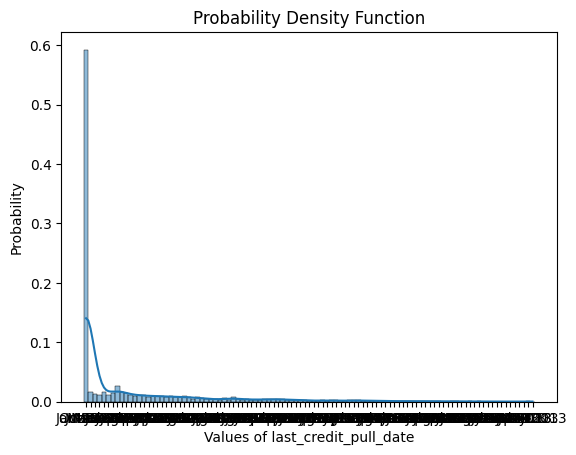

The mode of the distribution is Jan-2022
Plot for collections_12_mths_ex_med


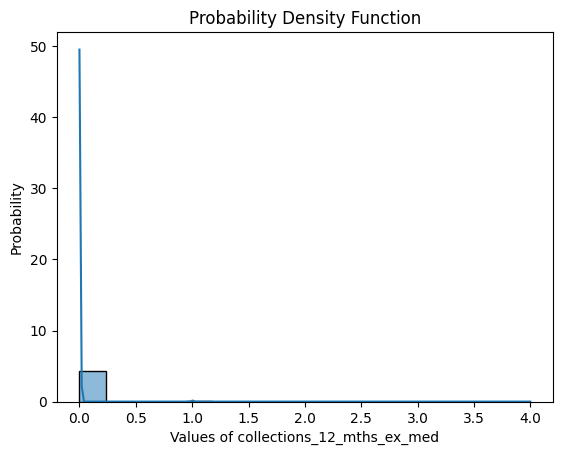

The mode of the distribution is 0.0
The mean of the distribution is 0.004208194905869324
The median of the distribution is 0.0


In [79]:
# We can see from this graphic that MCAR holds for all the nulls. Now we need to decide how to compute. Let's look at rhe distributions of the columns
plotter_1=db.Plotter()

for col in cols_with_nulls_ls:
    try:
        print(f'Plot for {col}')
        plotter_1.PDF_plot_with_averages(loan_payments, col)
    except:
        pass
        


In [80]:
# From this I can make some imputation decisisons.

dftransform_1 = db.DataFrameTransform()

dftransform_1.impute_mode(loan_payments, 'collections_12_mths_ex_med')
dftransform_1.impute_mode(loan_payments, 'last_credit_pull_date')
dftransform_1.impute_mode(loan_payments, 'last_payment_date')
dftransform_1.impute_mode(loan_payments, 'employment_length')
dftransform_1.impute_median(loan_payments, 'int_rate')
dftransform_1.impute_mode(loan_payments, 'term')


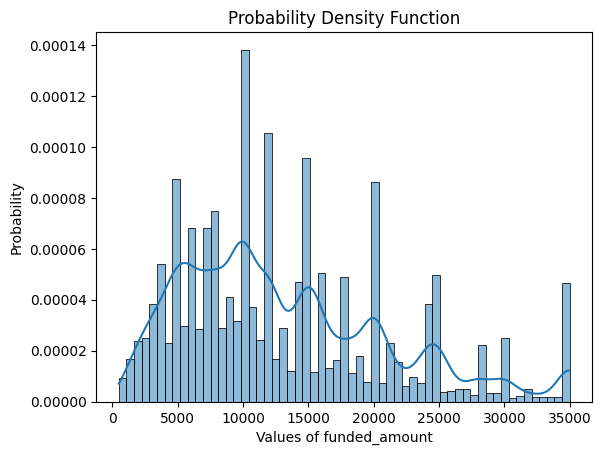

The mode of the distribution is 10000.0
The mean of the distribution is 13229.50911682024
The median of the distribution is 12000.0


In [81]:
# Last column to address because it didnt plot successfully, and impute!

plotter_1.PDF_plot_with_averages(loan_payments, 'funded_amount')
dftransform_1.impute_median(loan_payments, 'funded_amount')

In [82]:
# Changing all the datestring cols to iso format

datestring_cols = ['issue_date','earliest_credit_line','last_payment_date', 'last_credit_pull_date']
datatransformer_1 = db.DataTransform()
for column in datestring_cols:
    datatransformer_1.convert_datestrings_to_iso(loan_payments, column)


In [83]:
# Converting 'term' column to number of months
datatransformer_1= db.DataTransform()
# Need to first address nulls by imputing the mode
datatransformer_1.convert_monthstrings_to_float64(loan_payments, 'term')

In [84]:
# Converting 'employment_length' column into float64 object
datatransformer_1=db.DataTransform()
datatransformer_1.convert_yearstrings_to_float64_2(loan_payments, 'employment_length')


In [85]:
#%% Saving downloaded dataframe locally
csv_df_1 = db.CSV_DF()
csv_df_1.save_as_csv(loan_payments, 'loan_payments.csv')

In [86]:
# Removing rows that don't make sense

# If the total amount committed by investors > total amount committed then this doesn't make sense 

nonsense_mask_1 =  loan_payments['funded_amount_inv']>loan_payments['funded_amount']

loan_payments = loan_payments[~nonsense_mask_1]

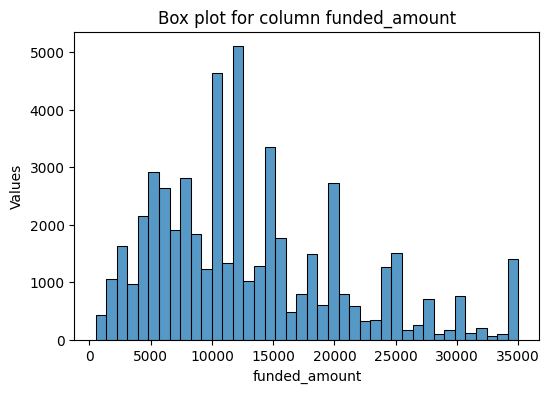

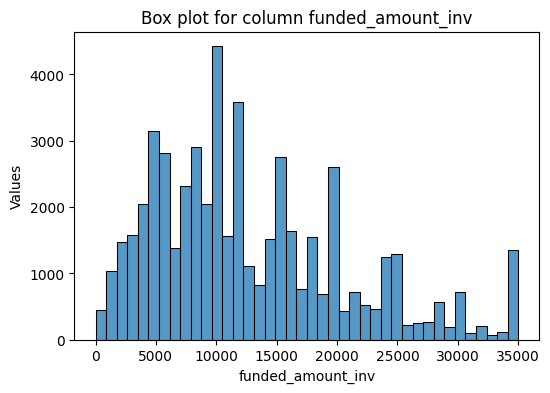

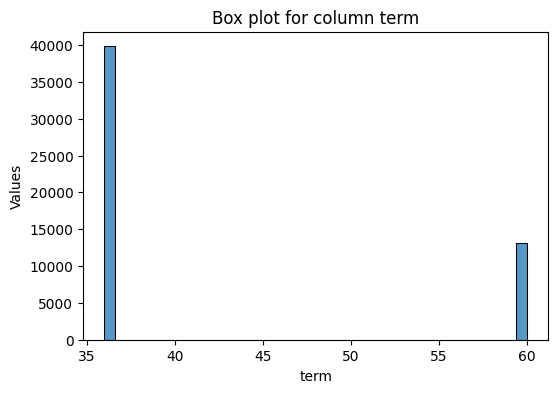

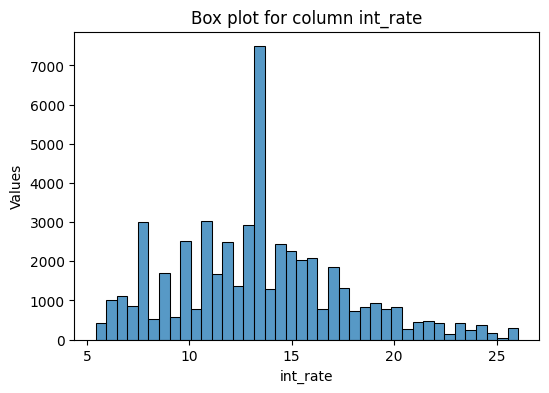

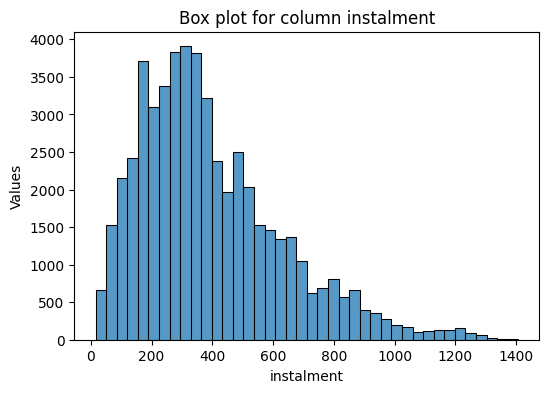

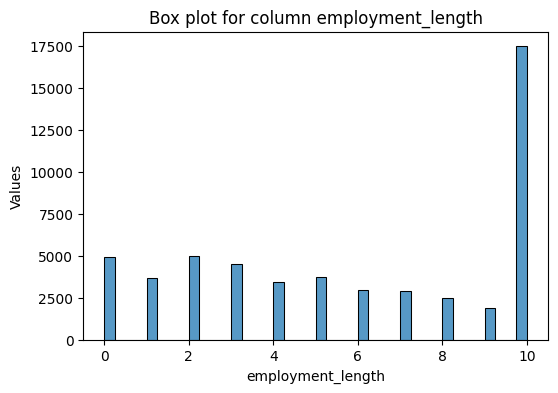

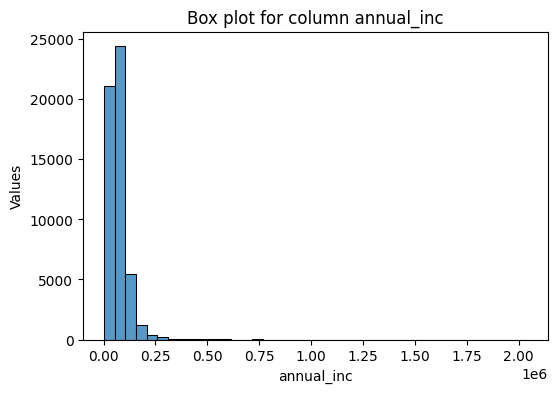

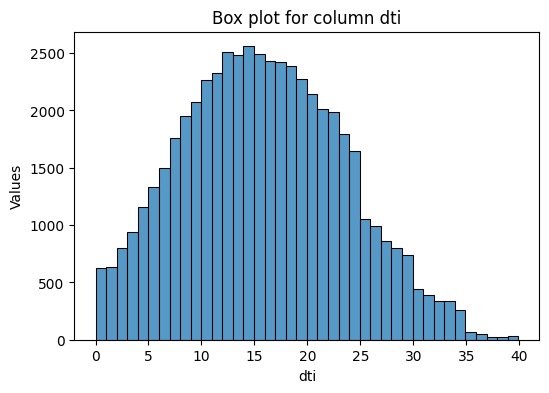

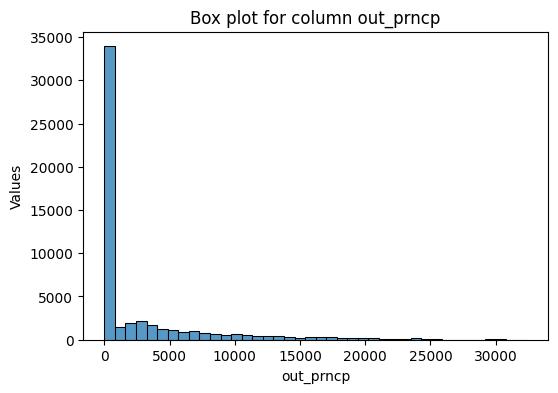

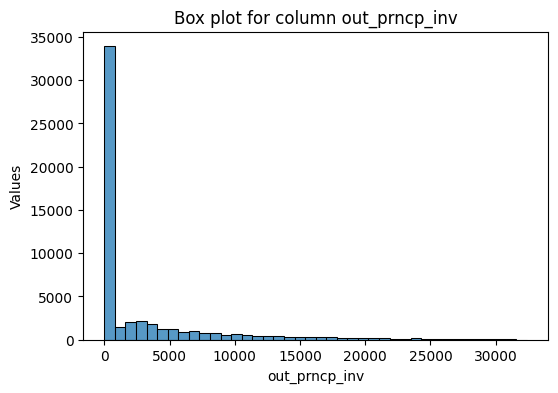

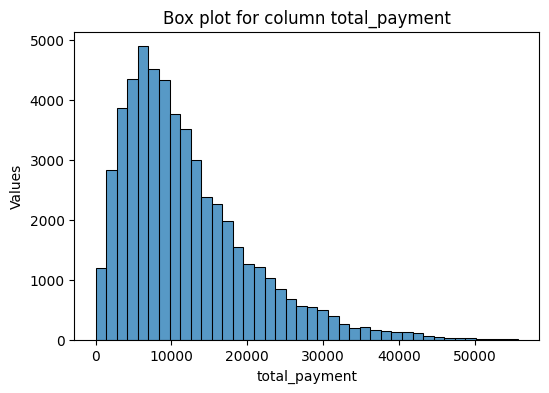

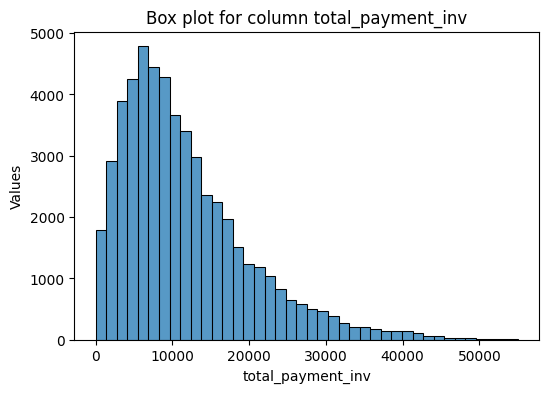

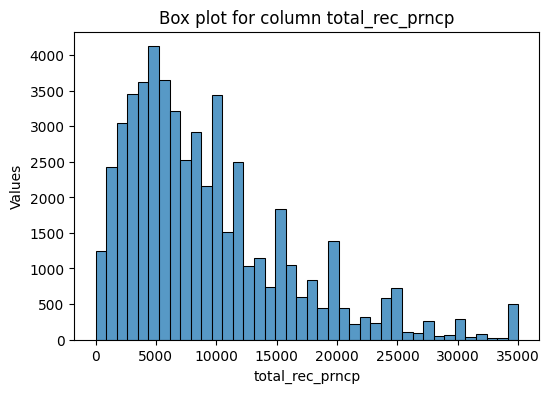

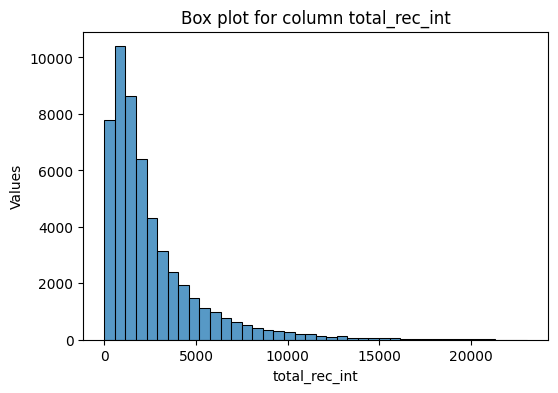

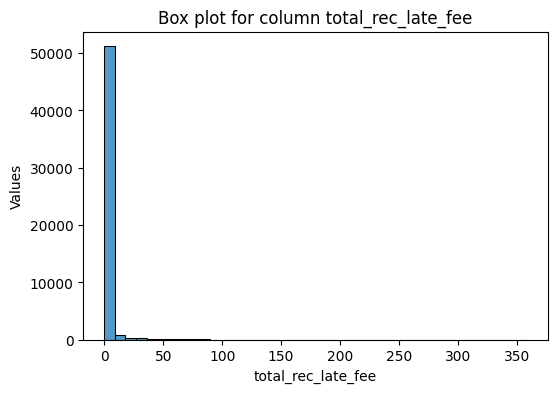

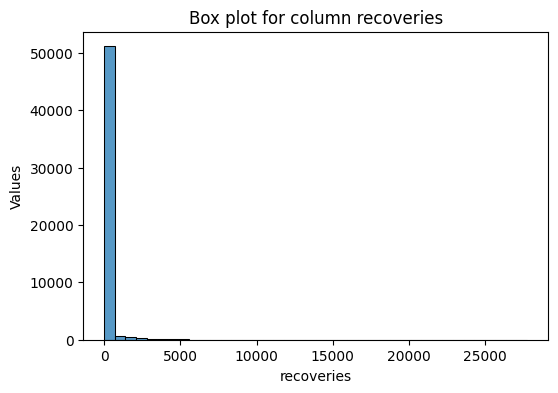

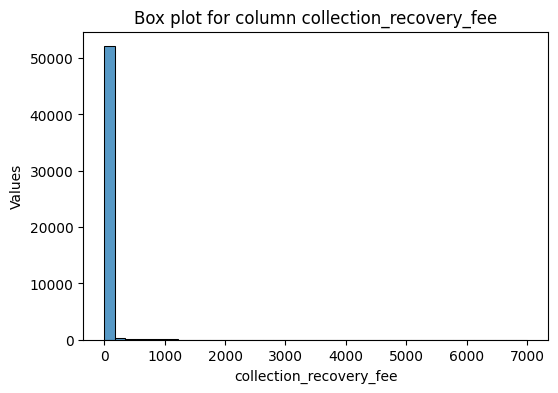

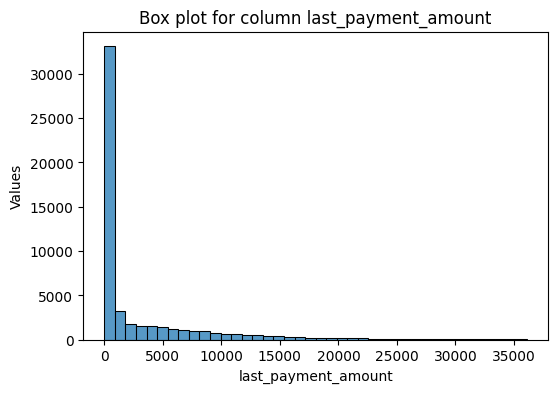

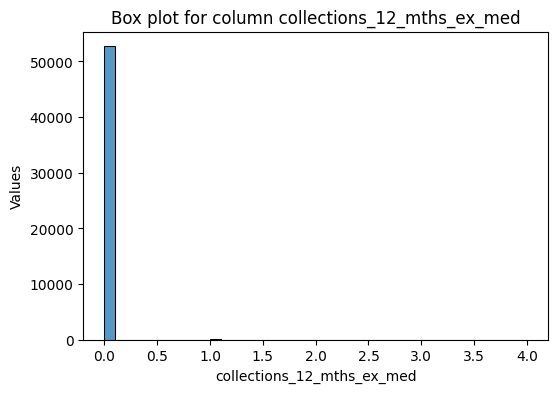

In [87]:
#  Histplots for all cols of dtype 'float64' to do visual inspection, looking for skew
plotter_1 = db.Plotter()
plotter_1.histplot_all_float_cols(loan_payments)

In [88]:
# Identifying which numeric columns are skewed and correcting skew using a Yeo-Johson transformation
dfinfo_1 = db.DataFrameInfo()
dftransform_1 = db.DataFrameTransform()
skewed_data = dfinfo_1.get_skews(loan_payments)

for i in range(0, len(skewed_data)-1):
    dftransform_1.yeojohnson_transformation(loan_payments, str(skewed_data[i]))
# Could in theory make this bit of code a method of DataTransformer class - ??

Skew of id: 2.37971127356059
Skew of member_id: 2.2137248254835127
Skew of loan_amount: 0.8371176559735031
Skew of funded_amount: 0.8490508352505961
Skew of funded_amount_inv: 0.846526605379939
Skew of term: 1.1701453712779786
Skew of int_rate: 0.45653870883646364
Skew of instalment: 1.023915028306138
Skew of employment_length: -0.17691844624196587
Skew of annual_inc: 8.896254131704941
Skew of dti: 0.18912422413246904
Skew of delinq_2yrs: 5.3802796319812325
Skew of inq_last_6mths: 3.268680911463738
Skew of open_accounts: 1.0640077709006284
Skew of total_accounts: 0.7833924967324051
Skew of out_prncp: 2.3978005956766864
Skew of out_prncp_inv: 2.398216965275574
Skew of total_payment: 1.2930992397809773
Skew of total_payment_inv: 1.2816555595112773
Skew of total_rec_prncp: 1.2838572177236351
Skew of total_rec_int: 2.239387144018402
Skew of total_rec_late_fee: 13.161641139867104
Skew of recoveries: 14.765662552136813
Skew of collection_recovery_fee: 27.384307090665782
Skew of last_payment_

In [89]:
# Observe correlation heatmap to look for colinearities
import plotly.express as px
dfinfo_1=db.DataFrameInfo()
px.imshow(loan_payments.corr(numeric_only=True), title="Correlation heatmap of student dataframe")

In [90]:
# If column correlation > 0.9 drop one of them
loan_payments_no_colinear = loan_payments.copy()

dftransform_1 = db.DataFrameTransform()
dftransform_1.drop_column(loan_payments_no_colinear, 'funded_amount_inv')
dftransform_1.drop_column(loan_payments_no_colinear, 'out_prncp_inv')
dftransform_1.drop_column(loan_payments_no_colinear, 'total_payment_inv')
dftransform_1.drop_column(loan_payments_no_colinear, 'total_rec_prncp')
dftransform_1.drop_column(loan_payments_no_colinear, 'funded_amount')
dftransform_1.drop_column(loan_payments_no_colinear, 'collection_recovery_fee')


In [91]:
# Observe again to check the colinearities have gone!

import plotly.express as px
dfinfo_1=db.DataFrameInfo()
px.imshow(loan_payments_no_colinear.corr(numeric_only=True), title="Correlation heatmap of student dataframe")

In [92]:
# One more to remove from colinear dataframe

dftransform_1.drop_column(loan_payments_no_colinear, 'instalment')

In [93]:
# Summarising what percentage of the loans are recovered against the investor funding and the total amount funded. 

loan_payments['prcnt_rec_inv_funding'] = (1 - (loan_payments['out_prncp_inv']/loan_payments['funded_amount_inv']))*100
loan_payments['prcnt_rec_total_funding'] = (1 - (loan_payments['out_prncp']/loan_payments['funded_amount']))*100



array([[<Axes: title={'center': 'prcnt_rec_inv_funding'}>,
        <Axes: title={'center': 'prcnt_rec_total_funding'}>]],
      dtype=object)

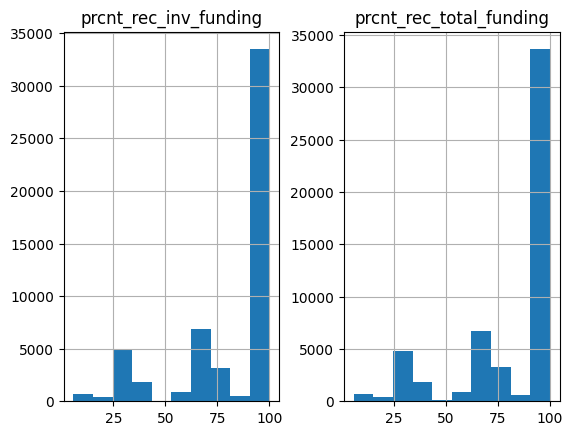

In [94]:
# Visualising my results on an appropriate graph.

hist_1 = loan_payments[['prcnt_rec_inv_funding', 'prcnt_rec_total_funding']].copy()

hist_1.hist()


In [96]:
# Additionally visualise what percentage of the total amount would be recovered up to 6 months' in the future.

loan_payments['prcnt_rec_total_funding_6mths'] = (1 +(6*loan_payments['instalment']/loan_payments['funded_amount']) - (loan_payments['out_prncp']/loan_payments['funded_amount']))*100

hist_1['prcnt_rec_total_funding_6mths'] = loan_payments['prcnt_rec_total_funding_6mths']

array([[<Axes: title={'center': 'prcnt_rec_inv_funding'}>,
        <Axes: title={'center': 'prcnt_rec_total_funding'}>],
       [<Axes: title={'center': 'prcnt_rec_total_funding_6mths'}>,
        <Axes: >]], dtype=object)

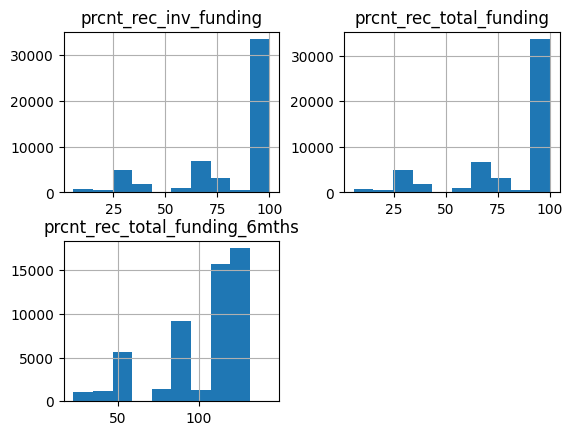

In [97]:
hist_1.hist()

In [ ]:
# Not sure what the correct interpretation of the task is 

